Source : https://github.com/k4r573n/OSM2Graph/blob/master/osm2graph.py

In [6]:
import xml.sax
from xml.sax.saxutils import XMLGenerator
import copy
import networkx

import sys
import argparse
from urllib.request import urlopen  #added ".request", urllib.urlopen discontinued since python 2.6

import matplotlib.pyplot as plt

import math
import urllib

In [2]:
verbose = 1
errors = 0

In [74]:
def vprint(stri,level):
    global verbose
    if verbose >= level:
        print(stri)

def getNetwork(left,bottom,right,top,transport="all"):
    """ Returns a filename to the downloaded data.
        down loads highways and public transport
    """
    bbox = "%f,%f,%f,%f"%(bottom,left,top,right)
    localfilename = "/tmp/input.osm"

    hw_query = ""
    if transport == "hw" or transport == "all":
        hw_query = ""+\
         "("+\
              "way("+bbox+")[highway];"+\
               ">;"+\
         ");"

    pt_query = ""
    if transport == "pt" or transport == "all":
        pt_query = ""+\
         "("+\
               "("+\
                   "relation("+bbox+")[type=route][route=tram];"+\
                   "relation("+bbox+")[type=route][route=bus];"+\
               ");"+\
               ">>;"+\
         ");"

       # pt_query = ""+\
       #  "("+\
       #        "("+\
       #             "relation[\"route_master\"=\"tram\"][\"network\"=\"VRB\"];"+\
       #        ");"+\
       #        ">>;"+\
       #  ");"
    meta = ""
    if (verbose >= 1):
        meta = " meta"

    api = "http://overpass-api.de/api/interpreter?data="
    url = ""+\
    "("+\
        hw_query+\
        pt_query+\
    ");"+\
    "out"+meta+";"

    vprint( api+url,2)

    url = api + urllib.quote(url)

    fp = urlopen( url )
    localFile = open(localfilename, 'w')
    localFile.write(fp.read())
    localFile.close()
    fp.close()
    return localfilename

In [75]:
# Node
#
# a class which represent a Openstreetmap-node as well as a graph vertex
class Node:
    def __init__(self, id, lon, lat):
        self.id = id
        self.lon = lon
        self.lat = lat
        self.tags = {}

    def checkTag(self,k,v):
        return k in self.tags and self.tags[k]==v


    # creats a osm-xml way object
    def toOSM(self,x,mark=False):
        # Generate SAX events
        frame = False
        if x == None :
            frame=True
            # Start Document
            x = XMLGenerator(sys.stdout, encoding="UTF-8")
            x.startDocument()
            x.startElement('osm',{"version":"0.6"})

        x.startElement('node',{"id":self.id, "lat":str(self.lat), "lon":str(self.lon), "visible":"true"})
        if mark:
            x.startElement('tag',{"k":'routing_crossing', "v":'yes'})
            x.endElement('tag')
        for k, v in self.tags.items():
            x.startElement('tag',{"k":k, "v":v})
            x.endElement('tag')
        x.endElement('node')
        if frame:
            x.endElement('osm')
            x.endDocument()

In [76]:
# Way
#
# a class which represent graph edges
# the ways includes split OSM-ways and PT-edges (between 2 stops)
class Way:
    def __init__(self, id, osm):
        self.osm = osm
        self.id = id
        self.nds = []
        self.tags = {}

    def split(self, dividers,ec):
        # slice the node-array using this nifty recursive function
        def slice_array(ar, dividers):
            for i in range(1,len(ar)-1):
                if dividers[ar[i]]>1:
                    #vprint( "slice at %s"%ar[i],2)
                    left = ar[:i+1]
                    right = ar[i:]
                    
                    rightsliced = slice_array(right, dividers)
                    
                    return [left]+rightsliced
            return [ar]
            
        slices = slice_array(self.nds, dividers)
        
        # create a way object for each node-array slice
        ret = []
        for slice in slices:
            littleway = copy.copy( self )
            littleway.id += "-"+str(ec)
            littleway.nds = slice
            ret.append( littleway )
            ec += 1
            
        return ret

    # creates a osm-xml way object
    def toOSM(self,x):
        # Generate SAX events
        frame = False
        if x == None :
            frame=True
            # Start Document
            x = XMLGenerator(sys.stdout, encoding="UTF-8")
            x.startDocument()
            x.startElement('osm',{"version":"0.6"})

        x.startElement('way',{"id":"-"+self.id.split("-",2)[1]})
        
        #bad but for rendering ok
        #x.startElement('way',{"id":self.id.replace("special","").split("-",2)[0]})
        for nid in self.nds:
            x.startElement('nd',{"ref":nid})
            x.endElement('nd')
        for k, v in self.tags.items():
            x.startElement('tag',{"k":k, "v":v}) 
            x.endElement('tag')
        x.endElement('way')
        if frame:
            x.endElement('osm')
            x.endDocument()

In [77]:
# Relation
#
# equals to an OSM-Relation
class Relation:
    # only for relations with type=route
    def __init__(self, id, osm):
        self.osm = osm
        self.id = id
        # members are a hash in a list (to give them a order) with format
        # [idx]={id:role}
        self.mnode = []
        self.mway = []
        self.mrelation = []
        self.tags = {}

    # creates a osm-xml relation object
    def toOSM(self,x):
        # Generate SAX events
        frame = False
        if x == None :
            frame=True
            # Start Document
            x = XMLGenerator(sys.stdout, encoding="UTF-8") #added encoding=
            x.startDocument()
            x.startElement('osm',{"version":"0.6"})

        x.startElement('relation',{"id":"-"+self.id.split("-",2)[1]})
        
        #bad but for rendering ok
        #x.startElement('way',{"id":self.id.replace("special","").split("-",2)[0]})
        for nid,role in map(lambda t: (t.items()[0]), self.mnode):
            x.startElement('member',{"type":"node", "ref":nid, "role":role})
            x.endElement('member')
        for wid,role in map(lambda t: (t.items()[0]), self.mway):
            x.startElement('member',{"type":"way", "ref":wid, "role":role})
            x.endElement('member')
        for rid,role in map(lambda t: (t.items()[0]), self.mrelation):
            x.startElement('member',{"type":"relation", "ref":rid, "role":role})
            x.endElement('member')
        for k, v in self.tags.items():
            x.startElement('tag',{"k":k, "v":v})
            x.endElement('tag')
        x.endElement('way')
        if frame:
            x.endElement('osm')
            x.endDocument()

In [78]:
# Route
#
# filled by Route-Relations for buses and trams
class Route:
    # only for relations with type=route
    def __init__(self, id, osm):
        self.osm = osm
        self.id = id
        self.stops = []
        self.platforms = []
        self.ways = []
        self.tags = {}

In [133]:
# OSM
#
# class to handel all tasks
# reads OSM file
# parse the data
# provide export functionalities
class OSM:
    """ will parse a osm xml file and provide different export functions"""
    def __init__(self, filename_or_stream, transport):
        """ File can be either a filename or stream/file object."""
        vprint( "Start reading input...",2)
        nodes = {} # node objects
        ways = {}# way objects
        vways ={}# old ID: [list of new way IDs] to use relations
        relations = {} # relation objects
        
        superself = self

        # OSMHandler
        #
        # reads the OSM-file
        class OSMHandler(xml.sax.ContentHandler):
            @classmethod
            def setDocumentLocator(self,loc):
                pass
            
            @classmethod
            def startDocument(self):
                pass
                
            @classmethod
            def endDocument(self):
                pass
                
            @classmethod
            def startElement(self, name, attrs):
                if name=='node':
                    self.currElem = Node(attrs['id'], float(attrs['lon']), float(attrs['lat']))
                elif name=='way':
                    self.currElem = Way(attrs['id'], superself)
                elif name=='relation':
                    self.currElem = Relation(attrs['id'], superself)
                elif name=='tag':
                    self.currElem.tags[attrs['k']] = attrs['v']
                elif name=='nd':
                    self.currElem.nds.append( attrs['ref'] )
                elif name=='member':
                    if attrs['type']=='node':
                        self.currElem.mnode.append({attrs['ref']:attrs['role']})
                    elif attrs['type']=='way':
                        self.currElem.mway.append({attrs['ref'] : attrs['role']})
                    elif attrs['type']=='relation':
                        self.currElem.mrelation.append({attrs['ref']:attrs['role']})
                    #else:
                        #ignore it
                
            @classmethod
            def endElement(self,name):
                if name=='node':
                    nodes[self.currElem.id] = self.currElem
                elif name=='way':
                    ways[self.currElem.id] = self.currElem
                elif name=='relation':
                    relations[self.currElem.id] = self.currElem
                
            @classmethod
            def characters(self, chars):
                pass

        xml.sax.parse(filename_or_stream, OSMHandler)
        
        self.nodes = nodes
        self.ways = ways
        self.relations = relations

        # edge counter - to generate continues numbered new edge ids
        ec = 0

        vprint( "file reading finished",1)
        vprint( "\nnodes: "+str(len(nodes)),1)
        vprint( "ways: "+str(len(ways)),1)
        vprint( "relations: "+str(len(relations))+"\n",1)

            
        """ prepare ways for routing """
        #count times each node is used
        node_histogram = dict.fromkeys( self.nodes.keys(), 0 )
        for way in self.ways.values():
            if len(way.nds) < 2:       #if a way has only one node, delete it out of the osm collection
                del self.ways[way.id]
            else:
                for node in way.nds:
                    #count public_transport=stop_position extra (to ensure a way split there)
                    if (transport=="all" or transport=="pt") and (\
                        nodes[node].checkTag('public_transport','stop_position') or 
                        nodes[node].checkTag('railway','tram_stop')):
                        node_histogram[node] += 2
                    else:
                        node_histogram[node] += 1

        
        #use that histogram to split all ways, replacing the member set of ways
        new_ways = {}
        for id, way in self.ways.items():   #problem with iteritems changed to items, iteritems deprecated
            split_ways = way.split(node_histogram,ec)
            ec += len(split_ways) #increase the counter 
            vways[way.id]=[]#lockup to convert old to new ids
            for split_way in split_ways:
                new_ways[split_way.id] = split_way
                vways[way.id].append(split_way.id)
        self.ways = new_ways
        self.vways = vways

        if not transport=="hw":
            self.addPublicTransport(ec)


    def checkPublicTransport(self):
        """ analyses which of the route relation is tagged correctly """
        routes = {}
        for r in self.relations.values():
            if not ('route' in r.tags and (r.tags['route']=='tram' or\
                    r.tags['route']=='bus')):
                continue

                # if stop number > = 2
# if number platform == number stops
# if all stops are nodes
# if all stops are at the beginning
# if stops and platforms are alternating

        return routes


    def addPublicTransport(self,ec):
        """ prepare route relations for routing """
        # error counter
        global errors
        
#TODO check if its well tagged before trying to add
        new_ways = {}
        for r in self.relations.values():
            if not ('route' in r.tags and (r.tags['route']=='tram' or\
                    r.tags['route']=='bus')):
                continue

            self.simplifyRoute(r)
            # parse this route and add the edges
            ec = self.route2edges(r, new_ways, ec)

        # add all new edges to the old ways
        vprint( "new and old ways",3)
        vprint( new_ways.keys(),3)
        vprint( self.ways.keys(),3)
        self.ways.update(new_ways)
        vprint( str(errors)+" Errors found\n",1)

    # substitutes all relation members by its' node and way members
    def simplifyRoute(self, rel, parent=None):
        
        vprint("simplify rel["+str(rel.id)+"] parent["+( str(parent.id) if
            parent != None else "")+"]",2);
        for subRelID,role in map(lambda t: (t.items()[0]), rel.mrelation):
            if 'route' in self.relations[subRelID].tags:
                # recursional calls
                self.simplifyRoute(self.relations[subRelID],rel)
#TODO delete the simplified relation out of the member list

        # add all nodes and ways to parent rel
        if parent != None:
            parent.mnode.extend(rel.mnode)
            parent.mway.extend(rel.mway)



    def route2edges(self, rel, new_ways, ec):
        # error counter
        global errors
        route_type = rel.tags['route']
        vprint( route_type,2)

        #extract stops
        stops = []
        #iterates through the items list (converted from hash)
        for nid,role in map(lambda t: t.items()[0], rel.mnode): 
            if role.split(':')[0]=='stop':
                stops.append(nid)
        vprint( str(len(stops))+" Stops found",2)

        tw = None
        # to turn the ways in the right direction
        last_node = None
        last_way = None
        i = 0
        #iterates through the items list (converted from hash)
        for old_wayid,role in map(lambda t: (t.items()[0]), rel.mway):
            if not (role=='forward' or role=='backward' or role==''):
                continue
            vprint( "\ntry adding Way["+str(old_wayid)+"]",2)
            vprint(self.vways[old_wayid],3)
            nds = []
            
            #first node out of first way
            fnode = self.ways[self.vways[old_wayid][0]].nds[0]

            #last node out of last way
            lnode = self.ways[self.vways[old_wayid][-1]].nds[-1]

            #check if node order is wrong
            invert = False
            if not last_node==None:
                if last_node==fnode:
                    invert = False
                elif last_node==lnode:
                    invert = True
                else:#ERROR
                    errors += 1
                    #idea to skip a route if an error was found
                    #TODO add this information to the check-report
                    vprint( "ERROR "+str(errors)+": Relation ["+str(rel.id)+"] in Way ["+str(old_wayid)+"] is not connected to the previous Way ["+str(last_way)+"]",0)
            else:
                invert = False

            last_way = old_wayid

            if invert:
                part_ways = self.vways[old_wayid][::-1]
                last_node = fnode
                vprint("invert way",2)
            else:
                part_ways = self.vways[old_wayid]
                last_node = lnode
                vprint("don't invert way",2)
            vprint( part_ways,3)

            #the next part hast to operate on the split ways
            for wayid in part_ways:
                if invert:
                    nds = self.ways[wayid].nds[::-1]
                else:
                    nds = self.ways[wayid].nds

                #skip if last stop was already reached
                if i>=len(stops):
                    break
                vprint( "waypart ["+str(wayid)+"] info: stop:"+str(i)+\
                        "["+stops[i]+"] \tn0: "+str(nds[0])+
                        "\tn-1:"+str(nds[-1]),2)
                #there are 2 different edges possible in kinds of stop position 0-x, 1-x
                #and it might be a continuing or the first edge
                if tw==None:
                    if stops[i]==nds[0]:
                        #its a new edge
                        tw = Way('special-'+str(ec),None) 
                        tw.tags = rel.tags;
                        tw.tags['highway']=route_type
                        tw.tags['oneway']="yes"#always oneway (one relation for each direction)
                        tw.nds.extend(nds) #all nodes have to belong to the edge cause way was split on stops

                        i += 1#jump to next stop_position
                        vprint( "create new Edge ["+str(tw.id)+"]",3)
                else:
                    if stops[i]==nds[0]:
                        #stop the last edge 
                        new_ways[tw.id] = tw
                        vprint("new wayid="+str(tw.id),3)
                        ec += 1

                        vprint( "finish edge ["+tw.id+"] and create new"+\
                                "Edge [special-"+str(ec)+"]",3)
                        #and start a new one
                        tw = Way('special-'+str(ec),None) 
                        tw.tags = rel.tags;
                        tw.tags['highway']= route_type
                        tw.tags['oneway']="yes"#always oneway (one relation for each direction)
                        tw.nds.extend(nds) #all nodes have to belong to the edge cause way was split on stops

                        i += 1#jump to next stop_position
                    else:
                        #just continue the last edge
                        tw.nds.extend(nds)
                        vprint( "continue Edge ["+str(tw.id)+"]",3)

        return ec
                        



    #calculates the way length in km
    # needs access to the nodes list - therefore its here
    def calclength(self,way):
        lastnode = None
        length = 0
        for node in way.nds:
            if lastnode is None:
                lastnode = self.nodes[node]
                continue

            # copied from
            # http://stackoverflow.com/questions/5260423/torad-javascript-function-throwing-error
            R = 6371 # km
            dLat = (lastnode.lat - self.nodes[node].lat) * math.pi / 180
            dLon = (lastnode.lon - self.nodes[node].lon) * math.pi / 180
            lat1 = self.nodes[node].lat * math.pi / 180
            lat2 = lastnode.lat * math.pi / 180
            a = math.sin(dLat/2) * math.sin(dLat/2) + math.sin(dLon/2) * math.sin(dLon/2) * math.cos(lat1) * math.cos(lat2)
            c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
            d = R * c

            length += d

            lastnode = self.nodes[node]

        return length

    # TODO rewrite to export to cvs
    # convert2mat
    #
    # return method for usage in Matlab
    # creates a *.m file with an edge and a node matrix where the edge/node id is
    # the row index
    def convert2mat(self,filename):
        vprint( "Matlab export to '"+filename+"'",1)

        # Edge
        #
        # inner class to represent an unidirectional and simplified edge for export
        class Edge:
            def __init__(self, eid, wayid, nds, tags, length):
                self.orgid = wayid
                self.id = eid
                self.dest = nds[-1]
                if "name" in tags:
                    self.name = tags["name"]
                else:
                    self.name = "no name"

                self.length = length

                hw={'footway':1, 'cycleway':2, 'path':1, 'residental':4,'motorway':3,'trunk':3,'motorway_link':3,'primary':3,
                        'secondary':3, 'tertiary':4, 'living_street':4, 'unclassified':4, 'service':4, 'track':2, 'steps':1,
                        'bus':5, 'tram':6}
                if "highway" in tags and tags["highway"] in hw:
                    self.highway = hw[tags["highway"]]
                else:
                    self.highway = 1# if unknown its a footway

                self.access_foot = 1
                if "foot" in tags and tags["foot"] == "no":
                    self.access_foot = 0
                self.access_bike = 1
                if "bicycle" in tags and tags["bicycle"] == "no":
                    self.access_bike = 0

            def toString(self):
                return "" + str(self.dest) + ", '" + self.name.replace("'", "''") + "', " + str(self.length) + ", " + str(self.highway) + ", " + str(self.access_foot) + ", " + str(self.access_bike) + ";"

        # Vertex
        #
        # inner class to represent a simplified node for export
        class Vertex:
            def __init__(self, id, lon, lat, eds, tags):
                self.id = id
                self.lon = lon
                self.lat = lat
                self.eds = []
                if "name" in tags:
                    self.name = tags["name"]
                else:
                    self.name = "no name"
                self.tags = {}

            def add_edge(self, edge):
                self.eds.append(edge)

            def toString(self):
                tempe = [str(i) for i in self.eds] + ["0"]*(10 - len(self.eds))
                edges = ", ".join(tempe)
                return "'"+self.name.replace("'", "''") + "', " + edges + ", " + str(self.lon) + ", " + str(self.lat) + ", " + str(self.id) +  ";"


        vertexes = []
        edges = []
        node_lu = {}
        eid = 0
        nid = 1
        for way in self.ways.values():
            if 'highway' not in way.tags:
                continue
            """ create 2 edges for each direction one """
            # add edge with way direction
            eid += 1
            edges.append(Edge(eid, way.id, way.nds, way.tags, self.calclength(way)))
            vprint( "eID: " + str(eid) + "\tdest: " + str(way.nds[-1]) + "\torg:" + str(way.nds[0]),3)

            if way.nds[0] in node_lu:
                vprint( "org: "+ str(way.nds[0]) + "new: " + str(node_lu[way.nds[0]]),3)
                vertexes[node_lu[way.nds[0]]-1].add_edge(eid)
            else:
                node = self.nodes[way.nds[0]]
                vprint( "add new id: " + str(node.id) + "=>" + str(nid),3)
                node_lu[str(node.id)] = nid # substitute the node id with array index
                vertexes.append(Vertex(node.id, node.lon, node.lon, [], node.tags))
                vertexes[nid-1].add_edge(eid)
                nid += 1

            # add edge against way direction
            eid += 1
            reversed_nodes = way.nds[::-1]
            edges.append(Edge(eid, way.id, reversed_nodes, way.tags, self.calclength(way)))

            if reversed_nodes[0] in node_lu:
                vprint( "org: "+ str(way.nds[0]) + "new: " + str(node_lu[way.nds[0]]),3)
                vertexes[node_lu[reversed_nodes[0]]-1].add_edge(eid)
            else:
                node = self.nodes[reversed_nodes[0]]
                vprint( "add new id: " + str(node.id) + "=>" + str(nid),3)
                node_lu[node.id] = nid # substitute the node id with array index
                vertexes.append(Vertex(node.id, node.lon, node.lon, [], node.tags))
                vertexes[nid-1].add_edge(eid)
                nid += 1

        # reduce node numbers
        for e in edges:
            e.dest = node_lu[e.dest]

        vprint( "saved to '"+filename+"'",1)
        f = open(filename, 'w')

        i = 0
        f.write("\n%[destination node ID, name, length, highway (1:footway, 2:cycleway, 3:big_street, 4:small_street, 5:bus, 6:tram), footaccess (0/1), bikeaccess (0/1)]\n")
        f.write("edges = {\n")
        for ed in edges:
            i += 1
            vprint( str(i) + ": " + ed.toString(),3)
            f.write( ed.toString()+"\n")
        f.write( "};\n\n")

        i = 0
        f.write( "%[name, 10 fields with edges, lon, lat, original ID]\n")
        f.write( "nodes = {\n")
        for v in vertexes:
          i+=1
          vprint( str(i)+": "+ v.toString(),3)
          f.write( v.toString() +"\n")
        f.write( "};\n\n")
        f.write("save('graph.mat','edges','nodes','-mat');")
        f.close()
        vprint( "run 'octave "+filename+"' to generate graph.mat to load in your program",2)

    # exports to osm xml
    def export(self,filename,transport):
        vprint( "osm-xml export...",1)

        #remember all nodes already exported
        unodes = {}

        fp = open(filename, "w")
        x = XMLGenerator(fp, "UTF-8")
        x.startDocument()
        x.startElement('osm',{"version":"0.6","generator":"crazy py script"})

        for w in self.ways.values():  #itervalues deprecated in python 3.0 --> changed to values
            if not 'highway' in w.tags:
                continue
            if transport == "all" or transport == "pt":
                if not (w.tags['highway']=='bus' or w.tags['highway']=='tram'):
                    continue
            if transport == "all" or transport == "hw":
                if (w.tags['highway']=='bus' or w.tags['highway']=='tram'):
                    continue
            w.toOSM(x)
            for nid in w.nds:
                if nid in unodes:#already used
                    continue
                unodes[nid]=True
                if w.nds.index(nid)==0 or w.nds.index(nid)==len(w.nds)-1:
                    self.nodes[nid].toOSM(x,True)
                else:
                    self.nodes[nid].toOSM(x)
        x.endElement('osm')
        x.endDocument()

    # returns a nice graph
    # attention do not use for a bigger network (only single lines)
    def graph(self,only_roads=True):
      G = networkx.Graph()

      for w in self.ways.values():
          if only_roads and 'highway' not in w.tags:
              continue
          G.add_weighted_edges_from([(w.nds[0],w.nds[-1],self.calclength(w))])
      for n_id in list(G.nodes(data=True)):  #changes according to https://stackoverflow.com/questions/33734836/graph-object-has-no-attribute-nodes-iter-in-networkx-module-python
          n = self.nodes[n_id[0]]  #changed from n_id to n_id[0]
          G.node[n_id[0]].update(dict(data=n))  #same + used .update()
      
      return G

    #def convert2neo4j(self,folder_to_put_db_in):
        #"""export in neo4j db formart"""

In [134]:
# main
#
# method to read the command line arguments and run the program
def main():
    parser = argparse.ArgumentParser(\
             description='This script provides you routeable data from the OpenStreetMap Project',
             epilog="Have fun while usage")
    #input selection
    group = parser.add_mutually_exclusive_group()
    group.add_argument('-f','--filename','--file', help='the path to a local file')
    group.add_argument("-b", "--bbox", help="an area to download highways in the format 'left,bottom,right,top'")
    parser.add_argument("-t", "--transport", choices=["all", "hw", "pt"], default="all",
            help="Experimental Option! Uses as well public transportation information")
    parser.add_argument("-o", "--osm-file", nargs='?', const='export.osm',
            help="export the routeable graph as osm-xml to given file")
            #type=argparse.FileType('w'),
    parser.add_argument("-m", "--matlab-file", nargs='?', const='export.m',
            help="export the routable graph as ugly Matlab file")
            #type=argparse.FileType('w'),
    parser.add_argument("-g", "--graph", help="show the routeable graph in a plot - only for smaller ones recommended",
                            dest="graph", action="store_true")
    parser.add_argument("-v", "--verbosity", type=int, choices=[0, 1, 2, 3],
                                help="increase output verbosity")
    args = parser.parse_args()

    #TODO ensure there is always an input - fix in argument syntax
    #bbox or filename
    global verbose
    verbose = 3 #args.verbosity
    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(0)

    #get the input
    fn = ""
    if True: #args.filename:
        fn = 'map(2).osm' #args.filename

    if args.bbox:
        [left,bottom,right,top] = [float(x) for x in args.bbox.split(",")]
        fn = getNetwork(left,bottom,right,top,args.transport)
    if fn==None:
        Sys.exit("ERROR: no input given")

    fp = open( fn,'r', encoding="utf-8" )  #added encoding="utf-u"
    osm = OSM(fp,"hw") #args.transport)
    fp.close()

    if True: #args.osm_file:
        vprint( "OSM-XML file export to '"+'output.osm-xml'+"'",1)  #initial : args.osm_file between the ++
        osm.export('output.osm-xml', 'hw')  #initial : args.osm_file,args.transport

    if args.matlab_file:
        vprint( "Export to Matlab file '"+args.matlab_file+"'",1)
        osm.convert2mat(args.matlab_file)

    if True: #args.graph:
        vprint( "Show as graph",1)
        G=osm.graph()
        networkx.draw(G)
        #networkx.draw_random(G)
        plt.show()
        #plt.savefig("path.png")

Start reading input...
file reading finished

nodes: 3922
ways: 373
relations: 150

OSM-XML file export to 'output.osm-xml'
osm-xml export...
Show as graph


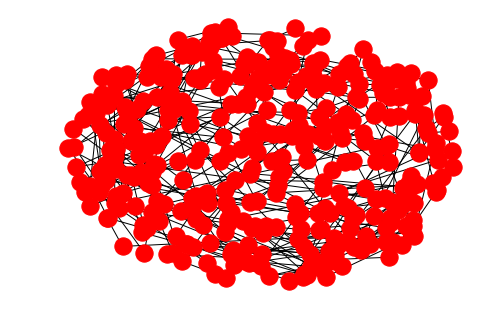

In [135]:
main()

In [ ]:
if __name__ == '__main__':
    main()